<a href="https://colab.research.google.com/github/cicichen57/CIS-5190-project/blob/main/ProjectMilestone3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# import libraries and packages
import pandas as pd
import numpy as np
import datetime as dt
import matplotlib.pyplot as plt
import math
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

In [ ]:
# import dataset
# please download the dataset here: https://github.com/zhouhaoyi/ETDataset/tree/main/ETT-small
df = pd.read_csv("ETTh1.csv")
df.head()

,date,HUFL,HULL,MUFL,MULL,LUFL,LULL,OT
0,2016-07-01 00:00:00,5.827,2.009,1.599,0.462,4.203,1.340,30.531000
1,2016-07-01 01:00:00,5.693,2.076,1.492,0.426,4.142,1.371,27.787001
2,2016-07-01 02:00:00,5.157,1.741,1.279,0.355,3.777,1.218,27.787001
3,2016-07-01 03:00:00,5.090,1.942,1.279,0.391,3.807,1.279,25.044001
4,2016-07-01 04:00:00,5.358,1.942,1.492,0.462,3.868,1.279,21.948000


In [ ]:
df.tail()

,date,HUFL,HULL,MUFL,MULL,LUFL,LULL,OT
17415,2018-06-26 15:00:00,-1.674,3.550,-5.615,2.132,3.472,1.523,10.904
17416,2018-06-26 16:00:00,-5.492,4.287,-9.132,2.274,3.533,1.675,11.044
17417,2018-06-26 17:00:00,2.813,3.818,-0.817,2.097,3.716,1.523,10.271
17418,2018-06-26 18:00:00,9.243,3.818,5.472,2.097,3.655,1.432,9.778
17419,2018-06-26 19:00:00,10.114,3.550,6.183,1.564,3.716,1.462,9.567


In [ ]:
#Augment Features to use in linear regression
df_aug = df.copy()
df_aug['HUFL_S'] = df_aug['HUFL']**2
df_aug['HULL_S'] = df_aug['HUFL']**2
df_aug['MUFL_S'] = df_aug['MUFL']**2
df_aug['LUFL_S'] = df_aug['LUFL']**2
df_aug['LULL_S'] = df_aug['LULL']**2
df_aug

,date,HUFL,HULL,MUFL,MULL,LUFL,LULL,OT,HUFL_S,HULL_S,MUFL_S,LUFL_S,LULL_S
0,2016-07-01 00:00:00,5.827,2.009,1.599,0.462,4.203,1.340,30.531000,33.953931,33.953931,2.556801,17.665210,1.795600
1,2016-07-01 01:00:00,5.693,2.076,1.492,0.426,4.142,1.371,27.787001,32.410247,32.410247,2.226064,17.156166,1.879641
2,2016-07-01 02:00:00,5.157,1.741,1.279,0.355,3.777,1.218,27.787001,26.594650,26.594650,1.635841,14.265729,1.483524
3,2016-07-01 03:00:00,5.090,1.942,1.279,0.391,3.807,1.279,25.044001,25.908102,25.908102,1.635841,14.493248,1.635841
4,2016-07-01 04:00:00,5.358,1.942,1.492,0.462,3.868,1.279,21.948000,28.708162,28.708162,2.226064,14.961424,1.635841
...,...,...,...,...,...,...,...,...,...,...,...,...,...
17415,2018-06-26 15:00:00,-1.674,3.550,-5.615,2.132,3.472,1.523,10.904000,2.802276,2.802276,31.528222,12.054783,2.319529
17416,2018-06-26 16:00:00,-5.492,4.287,-9.132,2.274,3.533,1.675,11.044000,30.162065,30.162065,83.393423,12.482089,2.805625
17417,2018-06-26 17:00:00,2.813,3.818,-0.817,2.097,3.716,1.523,10.271000,7.912969,7.912969,0.667489,13.808657,2.319529
17418,2018-06-26 18:00:00,9.243,3.818,5.472,2.097,3.655,1.432,9.778000,85.433050,85.433050,29.942785,13.359025,2.050624


In [ ]:
len(df)

17420

In [ ]:
df["OT"].max()

46.00699996948242

##DataLoader

In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler

In [ ]:
class Dataset_ETTh1(Dataset):
  def __init__(self, data, seq_len=None, label_len=None, gaussian_noise=None): 
    self.data = data

    # Use the data of the first 6 days to predict the OT of the seventh day as default
    if seq_len == None:
      self.seq_len = 24*6
    else:
      self.seq_len = seq_len

    if label_len == None:     
      self.label_len = 24
    else:
      self.label_len = label_len

    # the standard deviation of the noise added to the dataset
    if gaussian_noise == None:
      self.gaussian_noise = 0
    else:
      self.gaussian_noise = gaussian_noise

  def __len__(self):
    return len(self.data) - self.seq_len - self.label_len + 1

  def __getitem__(self, idx):
    # add random shift to the dataset
    noise_X = torch.randn(self.seq_len, self.data.shape[-1]) * self.gaussian_noise
    noise_y = torch.randn(self.label_len,) * self.gaussian_noise

    X = torch.Tensor(self.data[idx:idx+self.seq_len, :])
    y = torch.Tensor(self.data[idx+self.seq_len:idx+self.seq_len+self.label_len, -1]) # Only use row OT as label

    assert noise_X.shape == X.shape
    assert noise_y.shape == y.shape

    X = X + noise_X
    y = y + noise_y
    return X, y


In [ ]:
# Split the dataset in the ratio train:val:test = 6:2:2
train_idx = int(len(df) * 0.6)
val_idx = int(len(df) * 0.8)

df_data = df.drop(columns=['date'])

train_data = df_data[0:train_idx].values
val_data = df_data[train_idx:val_idx].values
test_data = df_data[val_idx:].values

# Normalize data
scaler = MinMaxScaler()
scaler.fit(train_data)

# Used to inverse_transform the labels back
label_scaler = MinMaxScaler()
label_scaler.fit(train_data[:,-1].reshape(-1, 1))

train_data_scaled = scaler.transform(train_data)
val_data_scaled = scaler.transform(val_data)
test_data_scaled = scaler.transform(test_data)

In [ ]:
train_set = Dataset_ETTh1(train_data_scaled)
val_set = Dataset_ETTh1(val_data_scaled)
test_set = Dataset_ETTh1(test_data_scaled)

train_dataloader = DataLoader(train_set, batch_size=32, shuffle=True)
val_dataloader = DataLoader(val_set, batch_size=32, shuffle=False)
test_dataloader = DataLoader(test_set, batch_size=1, shuffle=False)

In [ ]:
len(train_dataloader)

322

In [ ]:
# Split the augmented dataset in the ratio train:val:test = 6:2:2
train_idx = int(len(df_aug) * 0.6)
val_idx = int(len(df_aug) * 0.8)

df_aug_data = df_aug.drop(columns=['date'])

train_aug_data = df_aug_data[0:train_idx].values
val_aug_data = df_aug_data[train_idx:val_idx].values
test_aug_data = df_aug_data[val_idx:].values

# Normalize data
scaler = MinMaxScaler()
scaler.fit(train_aug_data)

# Used to inverse_transform the labels back
label_scaler = MinMaxScaler()
label_scaler.fit(train_aug_data[:,-1].reshape(-1, 1))

train_aug_data_scaled = scaler.transform(train_aug_data)
val_aug_data_scaled = scaler.transform(val_aug_data)
test_aug_data_scaled = scaler.transform(test_aug_data)

In [ ]:
train_aug_set = Dataset_ETTh1(train_aug_data_scaled)
val_aug_set = Dataset_ETTh1(val_aug_data_scaled)
test_aug_set = Dataset_ETTh1(test_aug_data_scaled)

train_aug_dataloader = DataLoader(train_aug_set, batch_size=32, shuffle=True)
val_aug_dataloader = DataLoader(val_aug_set, batch_size=32, shuffle=False)
test_aug_dataloader = DataLoader(test_aug_set, batch_size=32, shuffle=False)

In [ ]:
# The dataloader with noise added
train_aug_noise_set = Dataset_ETTh1(train_aug_data_scaled, gaussian_noise=0.05)
train_aug_noise_dataloader = DataLoader(train_aug_noise_set, batch_size=32, shuffle=True)

In [ ]:
len(train_aug_dataloader)

322

##Neural Network


###RNN

####Model

In [ ]:
# Define RNN model
class RNN(nn.Module):
  def __init__(self, input_size, hidden_size, output_size, num_layers, dropout):
    super(RNN, self).__init__()
    self.hidden_size = hidden_size
    self.num_layers = num_layers
    self.rnn = nn.RNN(input_size, hidden_size, num_layers, batch_first=True, dropout=dropout)
    self.fc = nn.Linear(hidden_size, output_size)
        
  def forward(self, x):
    h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
    _, hidden = self.rnn(x, h0)
    out = self.fc(hidden[-1, :, :])
    return out

####Training

In [ ]:
from torch.nn.utils.rnn import pad_sequence

In [ ]:
def training(model, num_epochs, criterion, optimizer, train_loader, val_loader, log=True):
  # Train RNN model
  train_loss_list = []
  val_loss_list = []
  for epoch in range(num_epochs):
    running_loss = 0.0
    for i, data in enumerate(train_loader):
      model.train()
      X, y = data
      optimizer.zero_grad()
      X_padded = pad_sequence(X, batch_first=True)
      X_padded = X
      y_pred = model(X_padded)
      loss = criterion(y_pred, y)
      loss.backward()
      optimizer.step()
      running_loss += loss.item()
      if i % 50 == 0:
        train_loss_list.append(running_loss / (i+1))

        # set model to evaluation mode
        model.eval()  
        val_loss = 0.0
        
        with torch.no_grad():
          for j, data in enumerate(val_loader):
            X, y = data
            X_padded = pad_sequence(X, batch_first=True)
            y_pred = model(X_padded)
            loss = criterion(y_pred, y)
            val_loss += loss.item()
          val_loss = val_loss / len(val_loader)
          val_loss_list.append(val_loss)

        if log:
          print('Epoch: {}, {} / {}, Training Loss: {:.4f}, Validation Loss: {:.4f}'.format(epoch+1, i, len(train_dataloader), running_loss / (i+1), val_loss))
  return train_loss_list, val_loss_list

Train Vanilla RNN without data shifting

In [ ]:
input_size = 7  
hidden_size = 64  
output_size = 24
num_layers = 1
dropout = 0

In [ ]:
RNN_model = RNN(input_size, hidden_size, output_size, num_layers, dropout)

# Define loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(RNN_model.parameters(), lr=0.0005)
num_epochs = 5

train_loss_list, val_loss_list = training(RNN_model, num_epochs, criterion, optimizer, train_dataloader, val_dataloader)

Epoch: 1, 0 / 322, Training Loss: 0.1976, Validation Loss: 0.0677
Epoch: 1, 50 / 322, Training Loss: 0.0834, Validation Loss: 0.0447
Epoch: 1, 100 / 322, Training Loss: 0.0526, Validation Loss: 0.0464
Epoch: 1, 150 / 322, Training Loss: 0.0396, Validation Loss: 0.0145
Epoch: 1, 200 / 322, Training Loss: 0.0315, Validation Loss: 0.0049
Epoch: 1, 250 / 322, Training Loss: 0.0261, Validation Loss: 0.0033
Epoch: 1, 300 / 322, Training Loss: 0.0224, Validation Loss: 0.0023
Epoch: 2, 0 / 322, Training Loss: 0.0044, Validation Loss: 0.0052
Epoch: 2, 50 / 322, Training Loss: 0.0038, Validation Loss: 0.0025
Epoch: 2, 100 / 322, Training Loss: 0.0037, Validation Loss: 0.0025
Epoch: 2, 150 / 322, Training Loss: 0.0037, Validation Loss: 0.0032
Epoch: 2, 200 / 322, Training Loss: 0.0036, Validation Loss: 0.0026
Epoch: 2, 250 / 322, Training Loss: 0.0036, Validation Loss: 0.0029
Epoch: 2, 300 / 322, Training Loss: 0.0036, Validation Loss: 0.0028
Epoch: 3, 0 / 322, Training Loss: 0.0025, Validation L

Plotting the loss trending

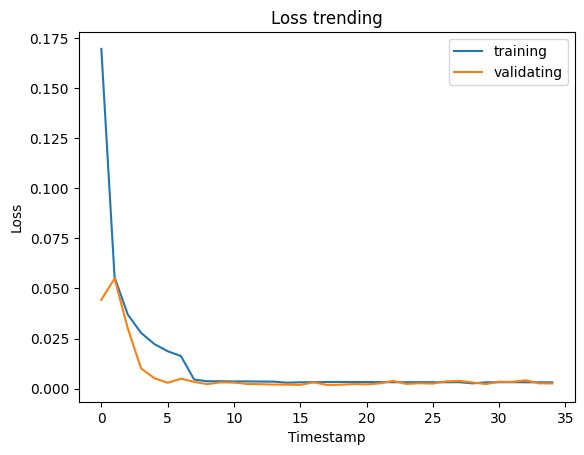

In [ ]:
import matplotlib.pyplot as plt

plt.plot(range(len(train_loss_list)), train_loss_list, label="training")
plt.plot(range(len(val_loss_list)), val_loss_list, label="validating")

plt.xlabel('Timestamp')
plt.ylabel('Loss')
plt.title('Loss trending')
plt.legend(loc="upper right")

plt.show()

####Testing

In [ ]:
def testing(model, criterion, test_loader):
  model.eval()  # set model to evaluation mode
  test_loss = 0.0
  y_pred_list = []
  y_gt_list = []
  with torch.no_grad():
    for x, y in test_loader:
      x_padded = pad_sequence(x, batch_first=True)
      y_pred = model(x_padded)
      loss = criterion(y_pred, y)
      test_loss += loss.item()

      # y_pred = label_scaler.inverse_transform(y_pred.numpy())
      # y = label_scaler.inverse_transform(y.numpy())

      y_pred_list.append(y_pred)
      y_gt_list.append(y)
    test_loss = test_loss / len(test_loader)

  print('Test Loss: {:.4f}'.format(test_loss))
  return y_pred_list, y_gt_list

In [ ]:
y_pred_list, y_gt_list = testing(RNN_model, criterion, test_dataloader)

Test Loss: 0.0019


#### Plotting Samples

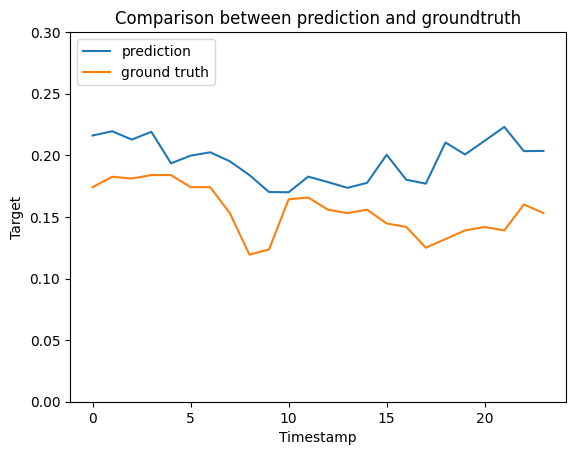

In [ ]:
plt.plot(range(24), y_pred_list[0][0], label="prediction")
plt.plot(range(24), y_gt_list[0][0], label="ground truth")

plt.xlabel('Timestamp')
plt.ylabel('Target')
plt.ylim([0, 0.3])
plt.title('Comparison between prediction and groundtruth')
plt.legend(loc="upper left")

#### Evaluating different hyperparameters

doubling the hidden size

In [ ]:
input_size = 7  
hidden_size = 128  
output_size = 24
num_layers = 1 
dropout = 0
RNN_model= RNN(input_size, hidden_size, output_size, num_layers, dropout)

In [ ]:
criterion = nn.MSELoss()
optimizer = optim.Adam(RNN_model.parameters(), lr=0.0005)
num_epochs = 5

train_loss_list, val_loss_list = training(RNN_model, num_epochs, criterion, optimizer, train_dataloader, val_dataloader, log=False)
y_pred_list, y_gt_list = testing(RNN_model, criterion, test_dataloader)

Test Loss: 0.0017


Multiple layers

In [ ]:
input_size = 7  
hidden_size = 128  
output_size = 24
num_layers = 2 
dropout = 0
RNN_model= RNN(input_size, hidden_size, output_size, num_layers, dropout)

In [ ]:
criterion = nn.MSELoss()
optimizer = optim.Adam(RNN_model.parameters(), lr=0.0005)
num_epochs = 5

train_loss_list, val_loss_list = training(RNN_model, num_epochs, criterion, optimizer, train_dataloader, val_dataloader, log=False)
y_pred_list, y_gt_list = testing(RNN_model, criterion, test_dataloader)

Test Loss: 0.0040


Multiple layers with dropout

In [ ]:
input_size = 7  
hidden_size = 128  
output_size = 24
num_layers = 2 
dropout = 0.5
RNN_model= RNN(input_size, hidden_size, output_size, num_layers, dropout)

In [ ]:
criterion = nn.MSELoss()
optimizer = optim.Adam(RNN_model.parameters(), lr=0.0005)
num_epochs = 5

train_loss_list, val_loss_list = training(RNN_model, num_epochs, criterion, optimizer, train_dataloader, val_dataloader, log=False)
y_pred_list, y_gt_list = testing(RNN_model, criterion, test_dataloader)

Test Loss: 0.0022


### Adding Data Shifting

5% noise

In [ ]:
# The dataloader with noise added
train_noise_set_1 = Dataset_ETTh1(train_data_scaled, gaussian_noise=0.05)
train_noise_dataloader_1 = DataLoader(train_noise_set_1, batch_size=32, shuffle=True)

In [ ]:
input_size = 7  
hidden_size = 128  
output_size = 24
num_layers = 1 
dropout = 0
RNN_model_2 = RNN(input_size, hidden_size, output_size, num_layers, dropout)

# Define loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(RNN_model_2.parameters(), lr=0.0005)
num_epochs = 5

# training with the shifted dataset
train_loss_list, val_loss_list = training(RNN_model_2, num_epochs, criterion, optimizer, train_noise_dataloader_1, val_dataloader)

Epoch: 1, 0 / 322, Training Loss: 0.1993, Validation Loss: 0.0495
Epoch: 1, 50 / 322, Training Loss: 0.0542, Validation Loss: 0.0569
Epoch: 1, 100 / 322, Training Loss: 0.0373, Validation Loss: 0.0329
Epoch: 1, 150 / 322, Training Loss: 0.0278, Validation Loss: 0.0047
Epoch: 1, 200 / 322, Training Loss: 0.0226, Validation Loss: 0.0022
Epoch: 1, 250 / 322, Training Loss: 0.0195, Validation Loss: 0.0029
Epoch: 1, 300 / 322, Training Loss: 0.0173, Validation Loss: 0.0019
Epoch: 2, 0 / 322, Training Loss: 0.0062, Validation Loss: 0.0025
Epoch: 2, 50 / 322, Training Loss: 0.0066, Validation Loss: 0.0027
Epoch: 2, 100 / 322, Training Loss: 0.0066, Validation Loss: 0.0018
Epoch: 2, 150 / 322, Training Loss: 0.0064, Validation Loss: 0.0025
Epoch: 2, 200 / 322, Training Loss: 0.0064, Validation Loss: 0.0018
Epoch: 2, 250 / 322, Training Loss: 0.0064, Validation Loss: 0.0036
Epoch: 2, 300 / 322, Training Loss: 0.0063, Validation Loss: 0.0022
Epoch: 3, 0 / 322, Training Loss: 0.0059, Validation L

In [ ]:
y_pred_list, y_gt_list = testing(RNN_model_2, criterion, test_dataloader)

Test Loss: 0.0024


10% noise

In [ ]:
# The dataloader with noise added
train_noise_set_2 = Dataset_ETTh1(train_data_scaled, gaussian_noise=0.1)
train_noise_dataloader_2 = DataLoader(train_noise_set_2, batch_size=32, shuffle=True)

In [ ]:
input_size = 7  
hidden_size = 128  
output_size = 24
num_layers = 1 
dropout = 0
RNN_model_3 = RNN(input_size, hidden_size, output_size, num_layers, dropout)

# Define loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(RNN_model_3.parameters(), lr=0.0005)
num_epochs = 5

# training with the shifted dataset
train_loss_list, val_loss_list = training(RNN_model_3, num_epochs, criterion, optimizer, train_noise_dataloader_2, val_dataloader)

Epoch: 1, 0 / 322, Training Loss: 0.2163, Validation Loss: 0.0583
Epoch: 1, 50 / 322, Training Loss: 0.0614, Validation Loss: 0.0388
Epoch: 1, 100 / 322, Training Loss: 0.0414, Validation Loss: 0.0061
Epoch: 1, 150 / 322, Training Loss: 0.0330, Validation Loss: 0.0039
Epoch: 1, 200 / 322, Training Loss: 0.0287, Validation Loss: 0.0033
Epoch: 1, 250 / 322, Training Loss: 0.0260, Validation Loss: 0.0048
Epoch: 1, 300 / 322, Training Loss: 0.0242, Validation Loss: 0.0021
Epoch: 2, 0 / 322, Training Loss: 0.0140, Validation Loss: 0.0019
Epoch: 2, 50 / 322, Training Loss: 0.0148, Validation Loss: 0.0025
Epoch: 2, 100 / 322, Training Loss: 0.0146, Validation Loss: 0.0026
Epoch: 2, 150 / 322, Training Loss: 0.0146, Validation Loss: 0.0026
Epoch: 2, 200 / 322, Training Loss: 0.0145, Validation Loss: 0.0035
Epoch: 2, 250 / 322, Training Loss: 0.0145, Validation Loss: 0.0041
Epoch: 2, 300 / 322, Training Loss: 0.0145, Validation Loss: 0.0024
Epoch: 3, 0 / 322, Training Loss: 0.0141, Validation L

In [ ]:
y_pred_list, y_gt_list = testing(RNN_model_3, criterion, test_dataloader)

Test Loss: 0.0027


### K-Folder


In [ ]:
from torch.utils.data import ConcatDataset
# keep the last split as the testing set
val_idx = int(len(df) * 0.8)

# Use 4-fold to divide the rest of the dataset into training and testing
idx_ratio = [0, 0.2, 0.4, 0.6, 0.8]
idx = [int(len(df) * x) for x in idx_ratio]
model_list = []

for i in range(len(idx) - 1):
  if i in [1, 2]:
    train_data_1 = df_data[0:idx[i]].values
    train_data_2 = df_data[idx[i+1]:val_idx].values

    train_data_scaled_1 = scaler.transform(train_data_1)
    train_data_scaled_2 = scaler.transform(train_data_2)


    train_set_1 = Dataset_ETTh1(train_data_scaled_1)
    train_set_2 = Dataset_ETTh1(train_data_scaled_2)

    train_set_all = ConcatDataset([train_set_1, train_set_2])

  elif i == 0:
    train_data_ = df_data[idx[i+1]:val_idx].values
    train_data_scaled_ = scaler.transform(train_data_)
    train_set_all = Dataset_ETTh1(train_data_scaled_)
  
  elif i == 3:
    train_data_ = df_data[0:idx[i]].values
    train_data_scaled_ = scaler.transform(train_data_)
    train_set_all = Dataset_ETTh1(train_data_scaled_)

  val_data = df_data[idx[i]:idx[i+1]].values
  val_set = Dataset_ETTh1(val_data_scaled)

  train_dataloader = DataLoader(train_set_all, batch_size=32, shuffle=True)
  val_dataloader = DataLoader(val_set, batch_size=32, shuffle=False)

  # training:
  RNN_model = RNN(input_size, hidden_size, output_size, num_layers, dropout)
  criterion = nn.MSELoss()
  optimizer = optim.Adam(RNN_model.parameters(), lr=0.0005)
  num_epochs = 5
  train_loss_list, val_loss_list = training(RNN_model, num_epochs, criterion, optimizer, train_dataloader, val_dataloader, log=False)
  model_list.append(RNN_model)
  print("model " + str(i) + " finished.")

   


model 0 finished.
model 1 finished.
model 2 finished.
model 3 finished.


In [ ]:
# keep the last split as the testing set
test_data = df_data[val_idx:].values
test_data_scaled = scaler.transform(test_data)
test_set = Dataset_ETTh1(test_data_scaled)
test_dataloader = DataLoader(test_set, batch_size=1, shuffle=False)

In [ ]:
y_pred_list_all = []
for i in range(len(model_list)):
  y_pred_list, y_gt_list = testing(model_list[i], criterion, test_dataloader)
  y_pred_list = np.stack(y_pred_list)
  y_pred_list_all.append(y_pred_list)

y_pred_list_all = np.array(y_pred_list_all)
y_pred_avg = np.mean(y_pred_list_all, axis=0)
y_pred_avg = y_pred_avg.reshape(-1, 24)
print(y_pred_avg.shape)

Test Loss: 0.0016
Test Loss: 0.0014
Test Loss: 0.0014
Test Loss: 0.0017
(3317, 24)


In [ ]:
y_gt_arr = np.stack(y_gt_list)
y_gt_arr = y_gt_arr.reshape(-1, 24)
print(y_gt_arr.shape)

(3317, 24)


In [ ]:
final_loss = criterion(torch.from_numpy(y_pred_avg), torch.from_numpy(y_gt_arr))
print(final_loss)

tensor(0.0013)


### LSTM

In [ ]:
# Define LSTM model
class LSTM(nn.Module):
  def __init__(self, input_size, hidden_size, output_size, num_layers, dropout):
    super(LSTM, self).__init__()
    self.hidden_size = hidden_size
    self.num_layers = num_layers
    self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True, dropout=dropout)
    self.fc = nn.Linear(hidden_size, output_size)
        
  def forward(self, x):
    h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size)
    c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size)
    out, _ = self.lstm(x, (h0, c0))
    out = self.fc(out[:, -1, :])
    return out

training LSTM without data shifting

In [ ]:
input_size = 7  
hidden_size = 64  
output_size = 24
num_layers = 1
dropout = 0
LSTM_model = LSTM(input_size, hidden_size, output_size, num_layers, dropout)

# Define loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(LSTM_model.parameters(), lr=0.0005)
num_epochs = 5

train_loss_list, val_loss_list = training(LSTM_model, num_epochs, criterion, optimizer, train_dataloader, val_dataloader)

Epoch: 1, 0 / 322, Training Loss: 0.1908, Validation Loss: 0.0591
Epoch: 1, 50 / 322, Training Loss: 0.1105, Validation Loss: 0.0368
Epoch: 1, 100 / 322, Training Loss: 0.0659, Validation Loss: 0.0421
Epoch: 1, 150 / 322, Training Loss: 0.0482, Validation Loss: 0.0218
Epoch: 1, 200 / 322, Training Loss: 0.0380, Validation Loss: 0.0185
Epoch: 1, 250 / 322, Training Loss: 0.0315, Validation Loss: 0.0127
Epoch: 1, 300 / 322, Training Loss: 0.0270, Validation Loss: 0.0099
Epoch: 2, 0 / 322, Training Loss: 0.0042, Validation Loss: 0.0091
Epoch: 2, 50 / 322, Training Loss: 0.0042, Validation Loss: 0.0080
Epoch: 2, 100 / 322, Training Loss: 0.0041, Validation Loss: 0.0078
Epoch: 2, 150 / 322, Training Loss: 0.0040, Validation Loss: 0.0065
Epoch: 2, 200 / 322, Training Loss: 0.0039, Validation Loss: 0.0073
Epoch: 2, 250 / 322, Training Loss: 0.0038, Validation Loss: 0.0070
Epoch: 2, 300 / 322, Training Loss: 0.0038, Validation Loss: 0.0054
Epoch: 3, 0 / 322, Training Loss: 0.0040, Validation L

In [ ]:
y_pred_list, y_gt_list = testing(LSTM_model, criterion, test_dataloader)

Test Loss: 0.0022


#### Adding K-folder

In [ ]:
input_size = 7  
hidden_size = 128
output_size = 24
num_layers = 1
dropout = 0

In [ ]:
from torch.utils.data import ConcatDataset
# keep the last split as the testing set
val_idx = int(len(df) * 0.8)

# Use 4-fold to divide the rest of the dataset into training and testing
idx_ratio = [0, 0.2, 0.4, 0.6, 0.8]
idx = [int(len(df) * x) for x in idx_ratio]
model_list = []

for i in range(len(idx) - 1):
  if i in [1, 2]:
    train_data_1 = df_data[0:idx[i]].values
    train_data_2 = df_data[idx[i+1]:val_idx].values

    train_data_scaled_1 = scaler.transform(train_data_1)
    train_data_scaled_2 = scaler.transform(train_data_2)


    train_set_1 = Dataset_ETTh1(train_data_scaled_1)
    train_set_2 = Dataset_ETTh1(train_data_scaled_2)

    train_set_all = ConcatDataset([train_set_1, train_set_2])

  elif i == 0:
    train_data_ = df_data[idx[i+1]:val_idx].values
    train_data_scaled_ = scaler.transform(train_data_)
    train_set_all = Dataset_ETTh1(train_data_scaled_)
  
  elif i == 3:
    train_data_ = df_data[0:idx[i]].values
    train_data_scaled_ = scaler.transform(train_data_)
    train_set_all = Dataset_ETTh1(train_data_scaled_)

  val_data = df_data[idx[i]:idx[i+1]].values
  val_set = Dataset_ETTh1(val_data_scaled)

  train_dataloader = DataLoader(train_set_all, batch_size=32, shuffle=True)
  val_dataloader = DataLoader(val_set, batch_size=32, shuffle=False)

  # training:
  LSTM_model = LSTM(input_size, hidden_size, output_size, num_layers, dropout)
  criterion = nn.MSELoss()
  optimizer = optim.Adam(LSTM_model.parameters(), lr=0.0005)
  num_epochs = 5
  train_loss_list, val_loss_list = training(LSTM_model, num_epochs, criterion, optimizer, train_dataloader, val_dataloader, log=False)
  model_list.append(LSTM_model)
  print("model " + str(i) + " finished.")

model 0 finished.
model 1 finished.
model 2 finished.
model 3 finished.


In [ ]:
# keep the last split as the testing set
test_data = df_data[val_idx:].values
test_data_scaled = scaler.transform(test_data)
test_set = Dataset_ETTh1(test_data_scaled)
test_dataloader = DataLoader(test_set, batch_size=1, shuffle=False)

In [ ]:
y_pred_list_all = []
for i in range(len(model_list)):
  y_pred_list, y_gt_list = testing(model_list[i], criterion, test_dataloader)
  y_pred_list = np.stack(y_pred_list)
  y_pred_list_all.append(y_pred_list)

y_pred_list_all = np.array(y_pred_list_all)
y_pred_avg = np.mean(y_pred_list_all, axis=0)
y_pred_avg = y_pred_avg.reshape(-1, 24)
print(y_pred_avg.shape)

Test Loss: 0.0015
Test Loss: 0.0018
Test Loss: 0.0014
Test Loss: 0.0020
(3317, 24)


In [ ]:
y_gt_arr = np.stack(y_gt_list)
y_gt_arr = y_gt_arr.reshape(-1, 24)
final_loss = criterion(torch.from_numpy(y_pred_avg), torch.from_numpy(y_gt_arr))
final_loss

tensor(0.0014)

#### Evaluating different hyperparameters

In [ ]:
input_size = 7  
hidden_size = 128  
output_size = 24
num_layers = 1 
dropout = 0
LSTM_model = LSTM(input_size, hidden_size, output_size, num_layers, dropout)

criterion = nn.MSELoss()
optimizer = optim.Adam(LSTM_model.parameters(), lr=0.0005)
num_epochs = 5

train_loss_list, val_loss_list = training(LSTM_model, num_epochs, criterion, optimizer, train_dataloader, val_dataloader, log=False)
y_pred_list, y_gt_list = testing(LSTM_model, criterion, test_dataloader)

Test Loss: 0.0015


In [ ]:
input_size = 7  
hidden_size = 128  
output_size = 24
num_layers = 2 
dropout = 0
LSTM_model = LSTM(input_size, hidden_size, output_size, num_layers, dropout)

criterion = nn.MSELoss()
optimizer = optim.Adam(LSTM_model.parameters(), lr=0.0005)
num_epochs = 5

train_loss_list, val_loss_list = training(LSTM_model, num_epochs, criterion, optimizer, train_dataloader, val_dataloader, log=False)
y_pred_list, y_gt_list = testing(LSTM_model, criterion, test_dataloader)

Test Loss: 0.0021


In [ ]:
input_size = 7  
hidden_size = 128  
output_size = 24
num_layers = 2 
dropout = 0.5
LSTM_model = LSTM(input_size, hidden_size, output_size, num_layers, dropout)

criterion = nn.MSELoss()
optimizer = optim.Adam(LSTM_model.parameters(), lr=0.0005)
num_epochs = 5

train_loss_list, val_loss_list = training(LSTM_model, num_epochs, criterion, optimizer, train_dataloader, val_dataloader, log=False)
y_pred_list, y_gt_list = testing(LSTM_model, criterion, test_dataloader)

Test Loss: 0.0023


##Linear Regression

###Data Preprocess

**Without Feature Augmentation**

In [ ]:
X = []
y = []
lr_train_dataloader = DataLoader(train_set, batch_size=1, shuffle=True)
for batch in lr_train_dataloader:
  X_batch, y_batch = batch
  X.append(X_batch.numpy().reshape([1, -1]))
  y.append(y_batch.numpy().reshape([1, -1]))
x_train = np.concatenate(X)
y_train = np.concatenate(y)

In [ ]:
x_train.shape

(10285, 1008)

In [ ]:
X = []
y = []
lr_test_dataloader = DataLoader(test_set, batch_size=1, shuffle=False)
for batch in lr_test_dataloader:
  X_batch, y_batch = batch
  X.append(X_batch.numpy().reshape([1, -1]))
  y.append(y_batch.numpy())

x_test = np.concatenate(X)
y_test = np.concatenate(y)

In [ ]:
x_test.shape

(3317, 1008)

**With Feature Augmentation**


In [ ]:
X = []
y = []
lr_train_aug_dataloader = DataLoader(train_aug_set, batch_size=1, shuffle=True)
for batch in lr_train_aug_dataloader:
  X_batch, y_batch = batch
  X.append(X_batch.numpy().reshape([1, -1]))
  y.append(y_batch.numpy().reshape([1, -1]))
x_aug_train = np.concatenate(X)
y_aug_train = np.concatenate(y)

In [ ]:
X = []
y = []
lr_test_aug_dataloader = DataLoader(test_aug_set, batch_size=1, shuffle=False)
for batch in lr_test_aug_dataloader:
  X_batch, y_batch = batch
  X.append(X_batch.numpy().reshape([1, -1]))
  y.append(y_batch.numpy())

x_aug_test = np.concatenate(X)
y_aug_test = np.concatenate(y)

In [ ]:
x_aug_test.shape

(3317, 1728)

###Linear Regression without Regularization

In [ ]:
from sklearn.linear_model import LinearRegression 
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet
from sklearn import metrics

In [ ]:
reg = LinearRegression() 
reg.fit(x_train, y_train) 
y_train_pred = reg.predict(x_train) 
y_test_pred = reg.predict(x_test) 

train_r2 = metrics.r2_score(y_train, y_train_pred)
train_mse = metrics.mean_squared_error(y_train, y_train_pred)

test_r2 = metrics.r2_score(y_test, y_test_pred)
test_mse = metrics.mean_squared_error(y_test, y_test_pred)

In [ ]:
print("The R2 of training data is " + str(train_r2))
print("The R2 of testing data is " + str(test_r2))
print("The MSE of training data is " + str(train_mse))
print("The MSE of testing data is " + str(test_mse))
print('Training Accuracy: {}'.format(reg.score(x_train, y_train)))
print('Test Accuracy: {}'.format(reg.score(x_test, y_test)))

The R2 of training data is 3.7432267933438606e-10
The R2 of testing data is -7.510338540328099
The MSE of training data is 0.028720595
The MSE of testing data is 0.03843539
Training Accuracy: 0.9250185970746228
Test Accuracy: 0.6535839733314462


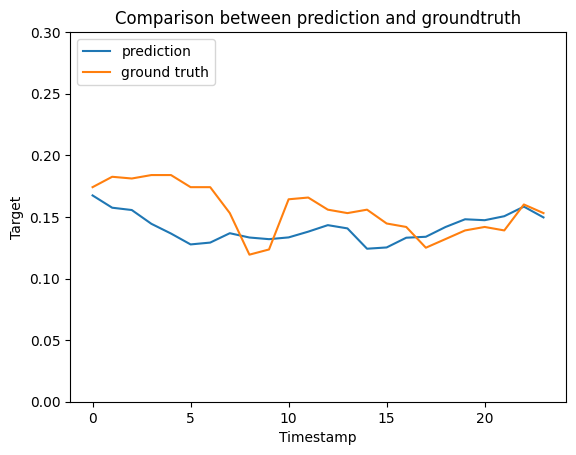

In [ ]:
plt.plot(range(24), y_test_pred[0], label="prediction")
plt.plot(range(24), y_test[0], label="ground truth")

plt.xlabel('Timestamp')
plt.ylabel('Target')
plt.ylim([0, 0.3])
plt.title('Comparison between prediction and groundtruth')
plt.legend(loc="upper left")

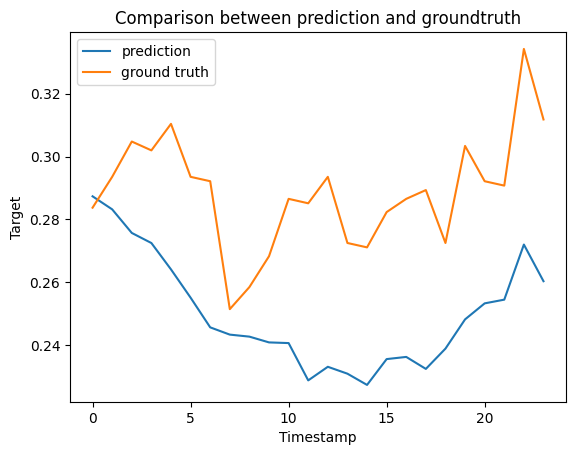

In [ ]:
plt.plot(range(24), y_train_pred[0], label="prediction")
plt.plot(range(24), y_train[0], label="ground truth")

plt.xlabel('Timestamp')
plt.ylabel('Target')
# plt.ylim([0, 0.3])
plt.title('Comparison between prediction and groundtruth')
plt.legend(loc="upper left")

###Linear Regression With Ridge Regularization

In [ ]:
ridge = Ridge() 
ridge.fit(x_train, y_train) 
y_train_pred = ridge.predict(x_train) 
y_test_pred = ridge.predict(x_test) 

train_r2 = metrics.r2_score(y_train, y_train_pred)
train_mse = metrics.mean_squared_error(y_train, y_train_pred)

test_r2 = metrics.r2_score(y_test, y_test_pred)
test_mse = metrics.mean_squared_error(y_test, y_test_pred)

In [ ]:
print("The R2 of training data is " + str(train_r2))
print("The R2 of testing data is " + str(test_r2))
print("The MSE of training data is " + str(train_mse))
print("The MSE of testing data is " + str(test_mse))
print('Training Accuracy: {}'.format(ridge.score(x_train, y_train)))
print('Test Accuracy: {}'.format(ridge.score(x_test, y_test)))

The R2 of training data is 0.9245586765796024
The R2 of testing data is 0.6608929642579477
The MSE of training data is 0.046531145
The MSE of testing data is 0.039110143
Training Accuracy: 0.9245586765796024
Test Accuracy: 0.6608929642579477


###Linear Regression with Feature Augmentation

In [ ]:
lr_aug = LinearRegression() 
lr_aug.fit(x_aug_train, y_aug_train) 
y_train_pred = lr_aug.predict(x_aug_train) 
y_test_pred = lr_aug.predict(x_aug_test) 

train_r2 = metrics.r2_score(y_aug_train, y_train_pred)
train_mse = metrics.mean_squared_error(y_aug_train, y_train_pred)

test_r2 = metrics.r2_score(y_aug_test, y_test_pred)
test_mse = metrics.mean_squared_error(y_aug_test, y_test_pred)

In [ ]:
print("The R2 of training data is " + str(train_r2))
print("The R2 of testing data is " + str(test_r2))
print("The MSE of training data is " + str(train_mse))
print("The MSE of testing data is " + str(test_mse))
print('Training Accuracy: {}'.format(reg.score(x_train, y_train)))
print('Test Accuracy: {}'.format(reg.score(x_test, y_test)))

The R2 of training data is 0.5955139923888639
The R2 of testing data is 0.43090996758926964
The MSE of training data is 0.0024522
The MSE of testing data is 0.005212622
Training Accuracy: 0.9250185970746228
Test Accuracy: 0.6535839733314462


## Classification

In [ ]:
df

In [ ]:
for i in range(10):
  print("The " + str(10*i) + " percent quantile of price is " + str(round(df['OT'].quantile(i/10),2)))

The 0 percent quantile of price is -4.08
The 10 percent quantile of price is 4.01
The 20 percent quantile of price is 6.05
The 30 percent quantile of price is 8.02
The 40 percent quantile of price is 9.78
The 50 percent quantile of price is 11.4
The 60 percent quantile of price is 13.79
The 70 percent quantile of price is 16.6
The 80 percent quantile of price is 19.77
The 90 percent quantile of price is 24.62


In [ ]:
df["OT"].max()

46.00699996948242

In [ ]:
#divide oil temperature into groups by percentile
c1 = df['OT'].quantile(0.25)
c2 = df['OT'].quantile(0.50)
c3 = df['OT'].quantile(0.75)
def divide_OT(x):
  if x < c1:
    return 0
  elif x < c2:
    return 1
  elif x < c3:
    return 2
  else:
    return 3
df["OT_group"] = df["OT"].apply(divide_OT).astype("float")

In [ ]:
features = df.drop(columns = ["date","OT","OT_group"])
OT_group = df["OT_group"]
seed = 42
random_state = seed
x_train, x_test, y_train, y_test = train_test_split(features, OT_group, test_size = 0.20, random_state=seed)

In [ ]:
#Standarization and PCA
scaler = StandardScaler()
scaler.fit(x_train)
scaled_x_train = scaler.transform(x_train)
scaled_x_test = scaler.transform(x_test)

pca = PCA(n_components=scaled_x_train.shape[1])
pca_x_train = pca.fit_transform(scaled_x_train)

In [ ]:
explained_variance_ratios =pca.explained_variance_ratio_
cum_evr = np.cumsum(pca.explained_variance_ratio_)

In [ ]:
plt.figure(figsize=(15,10))
n = scaled_x_train.shape[1]
p = plt.plot(np.arange(1,7),cum_evr)
plt.plot(np.arange(1,13), [0.95]*12)
plt.title('explained_variance_ratio v.s number of component')
plt.xlabel('number of component')
plt.ylabel('explained_variance_ratio')

In [ ]:
pca = PCA(n_components = 4)
x_train_pca = pca.fit_transform(scaled_x_train)
x_test_pca = pca.transform(scaled_x_test)

In [ ]:
from sklearn.linear_model import LogisticRegression

In [ ]:
log_reg_pca=LogisticRegression(penalty="l2",solver='liblinear')
log_reg_pca.fit(x_train_pca,y_train)
y_pred = log_reg_pca.predict(x_test_pca)
acc_reg_train = log_reg_pca.score(x_train_pca,y_train)
acc_reg_test = log_reg_pca.score(x_test_pca,y_test)

In [ ]:
print('Train Accuracy: '+ str(acc_reg_train))
print('Test Accuracy: '+ str(acc_reg_test))

Train Accuracy: 0.35376004592422505
Test Accuracy: 0.3567738231917336


## Random Forest

In [ ]:
from sklearn.ensemble import RandomForestClassifier

In [ ]:
rf = RandomForestClassifier(n_estimators = 15, max_depth = 15)
rf.fit(x_train, y_train)
train_pred_rf = rf.predict(x_train) 
test_pred_rf = rf.predict(x_test)

In [ ]:
acc_rf_train=rf.score(x_train,y_train)
acc_rf_test=rf.score(x_test,y_test)
print('Train Accuracy: '+ str(acc_rf_train))
print('Test Accuracy: ' + str(acc_rf_test))

Train Accuracy: 0.8987514351320322
Test Accuracy: 0.5315729047072331


## KNN

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score

In [ ]:
KNN = KNeighborsClassifier(n_neighbors=15, p = 2)
KNN.fit(x_train, y_train)
y_test = KNN.predict(x_test)
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

Accuracy: 0.40470723306544204
